<a href="https://colab.research.google.com/github/cbev/bross/blob/master/Calibrate_ANN_Landsat8Sentinel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
%tensorflow_version 2.x
import tensorflow as tf
print('tf version:',tf.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow_datasets as tfds
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

import io
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

# from google.colab import files
# uploaded = files.upload()
## upload df.csv

tf version: 2.2.0-rc2


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import the data and convert to values
import os
os.chdir('/content/drive/My Drive/BROSS')
df = pd.read_csv('calibration_data.csv') # assuming that saved in workspace already
df.drop(labels='Unnamed: 0',axis=1, inplace=True)
df.LID=df.LID.astype(int)

# Define which monitoring points:  Bahadurabad=1, Hardinge Bridge=2, Baruria=3, Mawa=4);
df=df[df['station'].isin([3,4])]
df=df.drop(labels=['station'],axis=1) # drop the 'station' label since want a generalized model that is not dependent on the location

# Define which satellite(s) to get data from- uncomment option: 2=Sentinel-2; 3=MODIS; 5, 7, 8= Landsat 5, 7, 8
### Landsat 8 and Sentinel-2
df=df[df['LID'].isin([2, 8])] 
#df=df.drop(labels=['total','month'],axis=1)
#df=df[['LID','blue','nir','red','gn','sp1','obs_mgL','month']] # testing using smaller group of variables
###df=df[['LID','rb','rn','rg','red','gn','sp1','obs_mgL','month']] # testing using smaller group of variables

df.reset_index(inplace=True, drop=True)
print('Variables:\n',df.head())
print(df.columns)

[ 8.          0.0691      0.0996      0.0526      0.097       0.3183
   1.40376266  0.97389558  1.84410646  0.0983      1.02649558 10.
 
# 7 [[ 8.          0.0681      0.0989      0.0983      0.0538      0.3191
#    1.45227606  1.00610376  1.83828996  0.0986      1.05990376 10.        ]] 2922.61328125

Variables:
    LID   blue   green     nir      obs_mgL    red   total        rb        rg  \
0  8    0.096  0.1380  0.1160  1057.313978  0.148  0.3820  1.541667  1.072464   
1  8    0.098  0.1170  0.0650  191.340171   0.089  0.3040  0.908163  0.760684   
2  8    0.074  0.0920  0.0400  191.463036   0.067  0.2330  0.905405  0.728261   
3  8    0.080  0.1285  0.0735  932.555485   0.137  0.3455  1.712500  1.066148   
4  8    0.087  0.1190  0.0600  831.943413   0.118  0.3240  1.356322  0.991597   

         rn      sp1       sp2  month  
0  1.275862  0.14300  1.188464  8      
1  1.369231  0.10300  0.825684  2      
2  1.675000  0.07950  0.768261  3      
3  1.863946  0.13275  1.139648  9      
4  1.966667  0.11850  1.051597  10     
Index(['LID', 'blue', 'green', 'nir', 'obs_mgL', 'red', 'total', 'rb', 'rg',
       'rn', 'sp1', 'sp2', 'month'],
      dtype='object')


        LID      blue     green       nir       red     total        rb  \
0  0.525226  0.332990  0.773265  1.735862  1.201688  0.871201  1.105491   
1  0.525226  0.421628 -0.105619  0.001494 -0.574101 -0.159719 -1.152754   
2  0.525226 -0.642025 -1.151909 -0.848687 -1.236260 -1.098121 -1.162585   
3  0.525226 -0.376111  0.375675  0.290555  0.870609  0.388783  1.714459   
4  0.525226 -0.065879 -0.021916 -0.168543  0.298744  0.104619  0.444794   

         rg        rn       sp1       sp2     month  
0  1.354182 -0.983690  1.039494  1.484558  0.280148  
1 -0.919826 -0.819473 -0.384421 -0.790662 -1.335252  
2 -1.156306 -0.281686 -1.220971 -1.150797 -1.066019  
3  1.308116  0.050631  0.674616  1.178403  0.549382  
4  0.764367  0.231296  0.167346  0.626179  0.818615  
Number of input variables: 12
Number of input data: 74


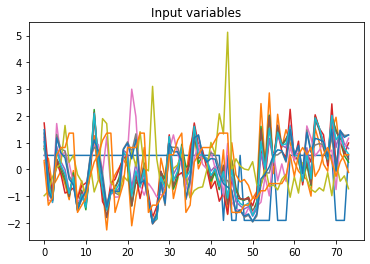

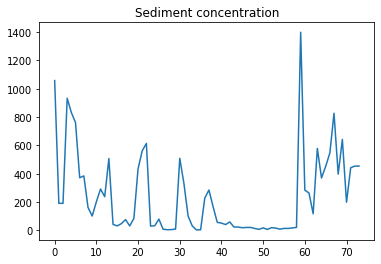

In [0]:
# Normalize the input data,
scale_inputs='yes'

if scale_inputs=='yes':
  df_prescaled = df.copy() # save a prescaled matrix
  df_scaled = df.drop(['obs_mgL'], axis=1)
  df_scaled = scale(df_scaled)
  cols = df.columns.tolist()
  cols.remove('obs_mgL')
  df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df.index)
  df_scaled = pd.concat([df_scaled, df['obs_mgL']], axis=1)
  df = df_scaled.copy()

# define input and output
X=df.drop(labels=['obs_mgL'],axis=1) #.values
y=df.obs_mgL.values
print(X.head()) 
       
plt.plot(X)
plt.title('Input variables')
plt.figure()
plt.plot(y)
plt.title('Sediment concentration')
print('Number of input variables:',X.shape[1])
print('Number of input data:',X.shape[0])

In [0]:
# Develop top ANN model
def model_base(input_dim):
  # define the keras model
  # Deep layer since a complex problem
  # add layers to the model- for each layers, define number of units and the activation function
  # use "relu' activation function to introduce non-linearity into the mode
 
  model = Sequential() # define type of model
  model.add(Dense(units=128, input_dim=input_dim, activation='relu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  model.add(Dense(64, activation= 'relu')) # hidden layer 1
  model.add(Dense(64, activation= 'relu')) # hidden layer 2
  model.add(Dense(32, activation= 'relu')) # hidden layer 3
  model.add(Dense(16, activation= 'relu')) # hidden layer 4
  model.add(Dense(16, activation= 'relu')) # hidden layer 5
  model.add(Dense(8, activation= 'relu')) # hidden layer 6
  model.add(Dense(8, activation= 'relu')) # hidden layer 8
  model.add(Dense(4, activation= 'relu')) # hidden layer 8
  model.add(Dense(1)) # since this is a regression problem, only one node in the ouput layers
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse']);

  return model

def run_ann(iterations, batch_size, epochs, test_size):
  # Split into training and testing data
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size)

  # develop the base model
  model=model_base(X_train.shape[1])

  # train and evaluate the model
  history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=False); # do not include validation data
  #history=model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=False); # include validation data 
  _, accuracy_top = model.evaluate(X_test, y_test) # evaluate based on the "testing" performance
  weights_top = model.get_weights()

  # Define the first parameters as the "top"
  X_train_top=X_train
  y_train_top=y_train
  X_test_top=X_test
  y_test_top=y_test
  history_top=history

  # do multiple iterations of training to model on different test/train splits
  for i in range (0,iterations-1):
    print(i)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size) 
    model=model_base(X_train.shape[1])
    history_i=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=False); # do not include validation data
    #history_i=model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=False); # include validation data 
    _, accuracy_i = model.evaluate(X_test, y_test); # evaluate based on the "testing" performance
    #_, accuracy_i = model.evaluate(X_train, y_train); # evaluate based on the "training" performance
    #_, accuracy_i = model.evaluate(np.concatenate([X_test, X_train]), np.concatenate([y_test, y_train])); # evaluate based on the overall performance
    weights_i = model.get_weights()

    if accuracy_i<accuracy_top:
      weights_top=weights_i;
      accuracy_top=accuracy_i;
      X_train_top=X_train
      y_train_top=y_train
      X_test_top=X_test
      y_test_top=y_test
      history_top=history_i
 
  return weights_top, accuracy_top, history_top, X_train_top, y_train_top, X_test_top, y_test_top


In [0]:
## ENTER INPUTS HERE AND RUN HERE!###
weights, accuracy, history, X_train, y_train, X_test, y_test= run_ann(iterations=10, batch_size=10, epochs=220, test_size=0.3)

# Set the model with the top weights
model=model_base(X_train.shape[1])
model.set_weights(weights)

fig1, (ax1, ax2, ax3) =plt.subplots(1,3,figsize=(20,5))
ax2.plot(model.predict(X_test),'r',label='ANN output')
ax2.plot(y_test,'k',label='Observed')
ax2.legend(loc='best')
ax2.set_title('Testing Data')
ax2.set_xlabel('Data Index Number')
ax2.set_ylabel('SSC (mg/L)')
_, accuracy = model.evaluate(X_test, y_test);

ax1.plot(model.predict(X_train),'r-',label='ANN output');
ax1.plot(y_train,'k-',label='Observed')
ax1.legend(loc='best')
ax1.set_title('Training Data')
ax1.set_xlabel('Data Index Number')
ax1.set_ylabel('SSC (mg/L)')
_, accuracy = model.evaluate(X_train, y_train);
xmax=1500
ymax=1500

ax3.plot([0,xmax], [0, xmax],'k-')
ax3.plot(y_train, model.predict(X_train),'ko', label='Training')
ax3.plot(y_test, model.predict(X_test), 'ro', label='Testing')
ax3.legend(loc='best')
ax3.set_title('ANN outputs vs Observations (SSC, mg/L)')
ax3.set_ylabel('ANN output')
ax3.set_xlabel('Observation')

axes = plt.gca()
axes.set_xlim([0,xmax])
axes.set_ylim([0,ymax])

r2_train = metrics.r2_score(y_train, model.predict(X_train));
r2_test = metrics.r2_score(y_test, model.predict(X_test));
r2_total = metrics.r2_score(np.concatenate([y_train, y_test]), np.concatenate([model.predict(X_train), model.predict(X_test)]));

#import matplotlib.pyplot as plt
_, accuracy = model.evaluate(X_test, y_test);
print('Test Error: %.2f' % (np.sqrt(accuracy)));
print ('Test r2', r2_test)
_, accuracy = model.evaluate(X_train, y_train);
print('Train Error: %.2f' % (np.sqrt(accuracy)))
print ('Train r2', r2_train)
print ('Total r2', r2_total)

# # Plot training & validation loss values
# plt.plot(history.history['mse'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper right')
# plt.show()

In [0]:
# SAVE MODEL
# NOTE: NEED TO CREATE A FOLDER WITH THE MODEL RUN NAME IN THE 'files' DIRECTORY
model_run='L8S2_v18' # only thing you should need to update

path='/content/drive/My Drive/Colab Notebooks/ann_files/'+model_run+'/'
model.save(path+model_run+'.h5')
np.save(path+'X_train_'+model_run,X_train,True)
np.save(path+'y_train_'+model_run,y_train,True)
np.save(path+'X_test_'+model_run,X_test,True)
np.save(path+'y_test_'+model_run,y_test,True)


In [0]:
# Save alternative model formats
os.chdir('/content/drive/My Drive/Colab Notebooks/ann_files/L8S2_v17')

# save to json
model_json = model.to_json()
with open("L8S2_v17_json.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")

# save to YAML- Note that this requires "PyYAML" package, which Colab has
model_yaml = model.to_yaml()
with open("L8S2_v17_yaml.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")

print("Saved models to disk")

Saved models to disk


1/1 [==============================] - 0s 2ms/step - loss: 19249.0195 - mean_squared_error: 19249.0195
Test Error: 138.74
Test r2 0.7409147233390332
Test ACC 0.859672554846286
Test anom -102.22607901200004
spearman: 0.8073122529644269
pearson: 0.7688499520451622
2/2 [==============================] - 0s 2ms/step - loss: 16367.1309 - mean_squared_error: 17055.9590
Train Error: 130.60
Train r2 0.8067261044429247
Total r2 0.7892413624007927


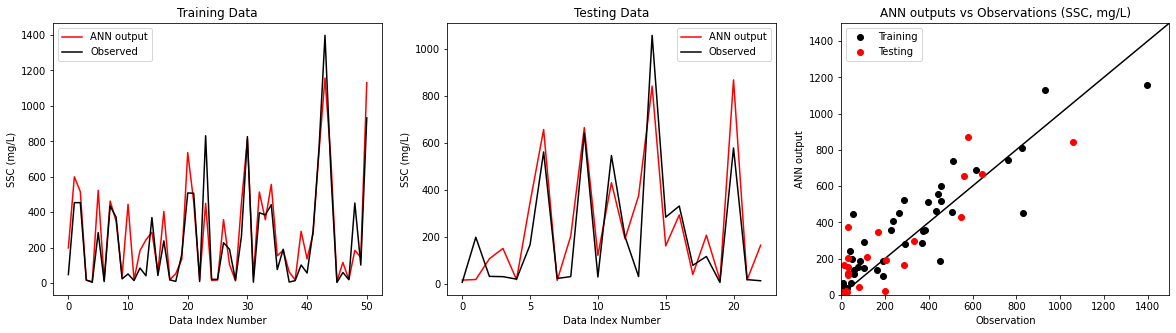

In [0]:
# LOAD A MODEL ALREADY SAVED
model_run='L8S2_v16' # only thing you should need to update

path='/content/drive/My Drive/Colab Notebooks/ann_files/'+model_run+'/'
model = tf.keras.models.load_model(path+model_run+'.h5')
X_train=np.load(path+'X_train_'+model_run+'.npy')
y_train=np.load(path+'y_train_'+model_run+'.npy')
X_test=np.load(path+'X_test_'+model_run+'.npy')
y_test=np.load(path+'y_test_'+model_run+'.npy')

# Compute ACC
pickle_in = open("/content/drive/My Drive/Colab Notebooks/ann_files/scale_matrix.pkl","rb")
scale_matrix = pickle.load(pickle_in)
## CHANGE FOR EACH SATELLITE: ##
X_test_orig=X_test*scale_matrix['L8S2_std']+scale_matrix['L8S2_mean']
test_month=np.empty(len(y_test))
i=0
for arrays in X_test_orig: 
  test_month[i]= int(arrays[-1])
  i=i+1
month_avg_obs={1:150.81, 2:186.01, 3:182.07, 4:200.84, 5:338.84, 6:330.69,
7:565.89, 8:528.65, 9:1077.08, 10:403.56, 11: 336.90, 12:225.09}
month_avg=np.empty(len(y_test))
i=0
for months in test_month:
  month_avg[i]=month_avg_obs[months]
  i=i+1
L8S2_mx=pd.DataFrame(data={'obs':y_test,'prediction': model.predict(X_test).flatten(),'month':test_month, 'month_avg':month_avg})
top=np.mean((L8S2_mx.prediction-L8S2_mx.month_avg)*(L8S2_mx.obs-L8S2_mx.month_avg))
bottom = np.sqrt(np.mean((L8S2_mx.prediction-L8S2_mx.month_avg)**2)*np.mean((L8S2_mx.obs-L8S2_mx.month_avg)**2))
ACC_L8S2=top/bottom

anom=np.mean(L8S2_mx.prediction-L8S2_mx.month_avg)

fig1, (ax1, ax2, ax3) =plt.subplots(1,3,figsize=(20,5))
ax2.plot(model.predict(X_test),'r',label='ANN output')
ax2.plot(y_test,'k',label='Observed')
ax2.legend(loc='best')
ax2.set_title('Testing Data')
ax2.set_xlabel('Data Index Number')
ax2.set_ylabel('SSC (mg/L)')
_, accuracy = model.evaluate(X_test, y_test);

ax1.plot(model.predict(X_train),'r-',label='ANN output');
ax1.plot(y_train,'k-',label='Observed')
ax1.legend(loc='best')
ax1.set_title('Training Data')
ax1.set_xlabel('Data Index Number')
ax1.set_ylabel('SSC (mg/L)')
_, accuracy = model.evaluate(X_train, y_train);
xmax=1500
ymax=1500

ax3.plot([0,xmax], [0, xmax],'k-')
ax3.plot(y_train, model.predict(X_train),'ko', label='Training')
ax3.plot(y_test, model.predict(X_test), 'ro', label='Testing')
ax3.legend(loc='best')
ax3.set_title('ANN outputs vs Observations (SSC, mg/L)')
ax3.set_ylabel('ANN output')
ax3.set_xlabel('Observation')

axes = plt.gca()
axes.set_xlim([0,xmax])
axes.set_ylim([0,ymax])

r2_train = metrics.r2_score(y_train, model.predict(X_train));
r2_test = metrics.r2_score(y_test, model.predict(X_test));
r2_total = metrics.r2_score(np.concatenate([y_train, y_test]), np.concatenate([model.predict(X_train), model.predict(X_test)]));

#import matplotlib.pyplot as plt
_, accuracy = model.evaluate(X_test, y_test);
print('Test Error: %.2f' % (np.sqrt(accuracy)));
print ('Test r2', r2_test)
print('Test ACC', ACC_L8S2)
print('Test anom', anom)
import scipy.stats
print('spearman:',scipy.stats.spearmanr(L8S2_mx.obs,L8S2_mx.prediction)[0])
print('pearson:',scipy.stats.pearsonr(L8S2_mx.obs,L8S2_mx.prediction)[0]**2)

_, accuracy = model.evaluate(X_train, y_train);
print('Train Error: %.2f' % (np.sqrt(accuracy)))
print ('Train r2', r2_train)
print ('Total r2', r2_total)


In [0]:
# Load aalternative model formats
# Issues with loading json, refer to here: https://stackoverflow.com/questions/53183865/unknown-initializer-glorotuniform-when-loading-keras-model

os.chdir('/content/drive/My Drive/Colab Notebooks/ann_files/L8S2_v17')

# load json and create model
json_file = open('L8S2_v17_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_weights.h5")

# load yaml and create model
yaml_file = open('L8S2_v17_yaml.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = tf.keras.models.model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded models from disk")
 

Loaded models from disk


In [0]:
# DO NOT RUN! This is code I tried but didn't end up using (just saving for now)

# Shallow model  
  
  #model.add(Dense(units=1, input_dim=X_train.shape[1], activation='elu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  #model.add(Dense(6, activation= 'elu')) # each successive node has hald the layers of predecessor
  #model.add(Dense(1)) # since this is a regression problem, only one node in the ouput layers


  ## Canonical Correlation Analysis 
  cca='no'
if cca=='yes':
  from sklearn.cross_decomposition import CCA
  cca = CCA(n_components=1)
  cca.fit(X, y)
  #CCA(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
  X,y = cca.transform(X, y)


# using cross validation

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def baseline_model():    
 # define the keras model
  model = Sequential() # define type of model
  # Deep layer since a complex problem
  # add layers to the model- for each layers, define number of units and the activation function
  # use "relu' activation function to introduce non-linearity into the mode; use 'elu' since will take exponential into account
  model.add(Dense(units=X_train.shape[1], input_dim=X_train.shape[1], activation='relu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  model.add(Dense(units=1)) # since this is a regression problem, only one node in the ouput layers
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  return model

def large_model():    
 # define the keras model
  model = Sequential() # define type of model
  model.add(Dense(units=128, input_dim=X_train.shape[1], activation='relu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  model.add(Dense(64, activation= 'relu')) # each successive node has hald the layers of predecessor
  model.add(Dense(32, activation= 'relu'))
  model.add(Dense(8, activation= 'relu'))
  model.add(Dense(1)) # since this is a regression problem, only one node in the ouput layers
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  return model  

# model = KerasRegressor(build_fn=baseline_model, epochs=500, verbose=0)
# # evaluate using 10-fold cross validation
# kfold = KFold(n_splits=10)
# results = cross_val_score(model, X, y, cv=kfold)
# print(results.mean())


estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=500, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))